In [1]:
%config IPCompleter.greedy=True
from IPython.display import IFrame

import pandas as pd
import numpy as np
import string
import math

import scipy.stats as sts

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn import preprocessing as prep
import sklearn.metrics as metrics
import sklearn.model_selection as model_selection
from sklearn import discriminant_analysis as disan
from sklearn import calibration as calib
from sklearn import linear_model as lm
from sklearn import svm
from sklearn import gaussian_process as gaup
from sklearn import mixture as mix
from sklearn import tree
from sklearn import ensemble as ens

import tensorflow as tf
from tensorflow import keras

# from keras import models as kermdls
# from keras import layers as kerlrs
# from keras import metrics as kmetrics

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe

import pickle

import nilearn as nl
from nilearn import plotting, image
from nilearn import datasets
import nibabel as nb
import h5py

Using TensorFlow backend.


In [20]:
tf.test.is_built_with_cuda()

True

In [20]:
tf.config.list_physical_devices()

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 579350234052576419
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5869078703593002555
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6589725830
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12037468935284227382
physical_device_desc: "device: 0, name: GeForce GTX 1070 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1322541900374533386
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
data = pd.read_csv('00_Data/train_scores.csv')
data

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
0,10001,57.436077,30.571975,62.553736,53.325130,51.427998
1,10002,59.580851,50.969456,67.470628,60.651856,58.311361
2,10004,71.413018,53.152498,58.012103,52.418389,62.536641
3,10005,66.532630,NaN,NaN,52.108977,69.993075
4,10007,38.617381,49.197021,65.674285,40.151376,34.096421
...,...,...,...,...,...,...
5872,21746,14.257265,21.358872,61.165998,51.778483,54.640179
5873,21747,55.456978,68.169675,29.907995,55.349257,54.019517
5874,21750,48.948756,55.114811,60.878271,38.617246,50.679885
5875,21752,66.532630,59.844808,72.303110,55.458281,46.870235


In [6]:
data.isnull().sum()

Id                0
age               0
domain1_var1    438
domain1_var2    438
domain2_var1     39
domain2_var2     39
dtype: int64

In [1]:
def load_individual_maps(patient_id, icn_idx, ntw_components):
        patient_SM = h5py.File('00_Data/fMRI_train/{0}.mat'.format(patient_id), mode='r')
        patient_SM = np.array(patient_SM.get('SM_feature'))

        patient_maps = {}
        for i in icn_idx.keys():
            component_maps = {}
            for j, _ in enumerate(icn_idx[i]):
                jj = ntw_components[i][j]
                component_maps[jj] = patient_SM[icn_idx[i]][j].transpose([2, 1, 0])
            patient_maps[i] = component_maps
        return patient_maps

In [8]:
def get_k_regions(sample_maps, ntw_labs, ntw_components, map_shape, k):
    arr_regions = []
    for ntw in ntw_labs:
        for c in ntw_components[ntw]:
            sample_map = sample_maps[ntw][c]
            # padding MRI map
            shape_pad = ((map_shape[0]//k + 1)*k - map_shape[0],
                         (map_shape[1]//k + 1)*k - map_shape[1],
                         (map_shape[2]//k + 1)*k - map_shape[2])

            npad = ((shape_pad[0]//2, (shape_pad[0]//2 if shape_pad[0]%2==0 else shape_pad[0]//2+1)),    
                    (shape_pad[1]//2, (shape_pad[1]//2 if shape_pad[1]%2==0 else shape_pad[1]//2+1)),    
                    (shape_pad[2]//2, (shape_pad[2]//2 if shape_pad[2]%2==0 else shape_pad[2]//2+1)))

            sample_map_padded = np.pad(sample_map, pad_width=npad, mode='constant', constant_values=0)

            sx = sample_map_padded.shape[0] / k
            sy = sample_map_padded.shape[1] / k
            sz = sample_map_padded.shape[2] / k
            for kz in range(k):
                for ky in range(k):
                    for kx in range(k):
                        ki_region = sample_map_padded[int(kx*sx): int(kx*sx + sx - 1), 
                                                     int(ky*sy): int(ky*sy + sy - 1), 
                                                     int(kz*sz): int(kz*sz + sz - 1)]
                        # padding i-th region by 3 pixels
                        ki_region_padded = np.pad(ki_region, pad_width=3, mode='constant', constant_values=0)
                        arr_regions.append(ki_region_padded)
    return np.stack(arr_regions, axis=3)

In [9]:
data = pd.read_csv('00_Data/train_scores.csv')

# Nifti MASK image
brain_mask = nb.load('00_Data/fMRI_mask.nii')

# load functional componets correlation matrix
fnc_10 = pd.read_csv('00_Data/fnc.csv')

# retrive unique network names with corresponding components
fnc10_cols = fnc_10.columns.to_list()[1:]
fnc10_cols_filtered = []
for i in fnc10_cols:
    fnc10_cols_filtered.append(i.split('_')[0])
    fnc10_cols_filtered.append(i.split('_')[2])
    
# Network index:
ntw_components = {}
ntw_labs = np.unique([i[:3] for i in fnc10_cols_filtered])
for ii in ntw_labs:
    ntw_components[ii] = np.unique([np.int(i.split('(')[-1].split(')')[0]) for i in fnc10_cols_filtered if ii in i])
    
# Look up matrix index
icn_number = pd.read_csv('00_Data/ICN_numbers.csv')

# create dictionary of networks with corresponding components
icn_idx = {}
for jj in ntw_components.keys():
    icn_idx[jj] = np.array(icn_number.index[icn_number['ICN_number'].isin(ntw_components[jj])])

In [10]:
target = 'age'

train, test = model_selection.train_test_split(data, test_size=0.1)
train, val = model_selection.train_test_split(train, test_size=0.2)
X_train = train['Id']
X_val = val['Id']
X_test = test['Id']
Y_train = train[target]
Y_val = val[target]
Y_test = test[target]

In [11]:
train.head()

,Id,age,domain1_var1,domain1_var2,domain2_var1,domain2_var2
1188,12380,38.617381,44.061580,69.053375,43.488447,59.656328
2381,14796,51.996514,57.493468,48.005744,38.412873,42.470931
3168,16392,50.427747,51.969295,59.785820,48.841025,59.685470
5482,21003,59.580851,NaN,NaN,58.259300,59.327780
4568,19193,53.583805,55.966272,54.793583,26.257133,43.415771


In [12]:
l = list(X_train)
mps = load_individual_maps(l[0], icn_idx, ntw_components)
regs = get_k_regions(mps, ntw_labs, ntw_components, (53,63,52), 2)

In [13]:
INPUT_SHAPE = regs.shape

In [14]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, ntw_labs, ntw_components, icn_idx, mri_map_shape=(53,63,52), k=2, batch_size=32, shuffle=True):
        'Initialization'
        self.X = list(data['Id'])
        self.y = list(data['age'])
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.ntw_labs = ntw_labs
        self.ntw_components = ntw_components
        self.icn_idx = icn_idx
        self.sample_shape0 = mri_map_shape
        self.k = k
        
    def __load_individual_maps(self, patient_id, icn_idx, ntw_components):
        patient_SM = h5py.File('00_Data/fMRI_train/{0}.mat'.format(patient_id), mode='r')
        patient_SM = np.array(patient_SM.get('SM_feature'))

        patient_maps = {}
        for i in icn_idx.keys():
            component_maps = {}
            for j, _ in enumerate(icn_idx[i]):
                jj = ntw_components[i][j]
                component_maps[jj] = patient_SM[icn_idx[i]][j].transpose([2, 1, 0])
            patient_maps[i] = component_maps
        return patient_maps
    
    def __get_k_regions(self, sample_maps, ntw_labs, ntw_components, map_shape, k):
        # iterate through mri maps of the subject
        # split each map by k**3 regions and concatenate these regions along channel dimension
        arr_regions = []
        for ntw in ntw_labs:
            for c in ntw_components[ntw]:
                sample_map = sample_maps[ntw][c]
                # padding MRI map
                shape_pad = ((map_shape[0]//k + 1)*k - map_shape[0],
                             (map_shape[1]//k + 1)*k - map_shape[1],
                             (map_shape[2]//k + 1)*k - map_shape[2])

                npad = ((shape_pad[0]//2, (shape_pad[0]//2 if shape_pad[0]%2==0 else shape_pad[0]//2+1)),    
                        (shape_pad[1]//2, (shape_pad[1]//2 if shape_pad[1]%2==0 else shape_pad[1]//2+1)),    
                        (shape_pad[2]//2, (shape_pad[2]//2 if shape_pad[2]%2==0 else shape_pad[2]//2+1)))

                sample_map_padded = np.pad(sample_map, pad_width=npad, mode='constant', constant_values=0)

                sx = sample_map_padded.shape[0] / k
                sy = sample_map_padded.shape[1] / k
                sz = sample_map_padded.shape[2] / k
                for kz in range(k):
                    for ky in range(k):
                        for kx in range(k):
                            ki_region = sample_map_padded[int(kx*sx): int(kx*sx + sx - 1), 
                                                         int(ky*sy): int(ky*sy + sy - 1), 
                                                         int(kz*sz): int(kz*sz + sz - 1)]
                            
                            # padding i-th region by 3 pixels
                            ki_region_padded = np.pad(ki_region, pad_width=3, mode='constant', constant_values=0)
                            arr_regions.append(ki_region_padded)
        return np.stack(arr_regions, axis=3)
        

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        X_batch = [self.X[i] for i in indexes]
        y_batch = [self.y[i] for i in indexes]

        # Generate data
        X_batch = self.__data_generation(X_batch)

        return X_batch, np.array(y_batch)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_input):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # iterate through subjects in the batch
        X = []
        for i in batch_input:
            sample_maps = self.__load_individual_maps(i, self.icn_idx, self.ntw_components)
            X.append(self.__get_k_regions(sample_maps, self.ntw_labs, self.ntw_components, self.sample_shape0, self.k))
        return np.array(X)

In [15]:
inputs = keras.layers.Input(shape=INPUT_SHAPE)
print(inputs)

# convolution block #1
block_1 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), activation='elu')(inputs)
print(block_1)
block_1 = keras.layers.Conv3D(64, kernel_size=(3, 3, 3), strides=(1,1,1), activation='elu')(block_1)
print(block_1)
block_1 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(1,1,1))(block_1)
print(block_1)
block_1 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_1)
print(block_1, '\n')


# convolution block #2
block_2 = keras.layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1,1,1), activation='elu')(block_1)
print(block_2)
block_2 = keras.layers.Conv3D(32, kernel_size=(3, 3, 3), strides=(1,1,1), activation='elu')(block_2)
print(block_2)
block_2 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(1,1,1))(block_2)
print(block_2)
block_2 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_2)
print(block_2, '\n')

# convolution block #3
block_3 = keras.layers.Conv3D(16, kernel_size=(3, 3, 3), strides=(1,1,1), activation='elu')(block_2)
print(block_3)
block_3 = keras.layers.Conv3D(16, kernel_size=(3, 3, 3), strides=(1,1,1), activation='elu')(block_3)
print(block_3)
block_3 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(1,1,1))(block_3)
print(block_3)
block_3 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_3)
print(block_3, '\n')

# convolution block #4
block_4 = keras.layers.Conv3D(8, kernel_size=(3, 3, 3), strides=(1,1,1), activation='elu')(block_3)
print(block_4)
block_4 = keras.layers.Conv3D(8, kernel_size=(3, 3, 3), strides=(1,1,1), activation='elu')(block_4)
print(block_4)
block_4 = keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(1,1,1))(block_4)
print(block_4)
block_4 = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, 
                                          beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros',
                                          moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, 
                                          beta_constraint=None, gamma_constraint=None)(block_4)
print(block_4, '\n')

flatten = keras.layers.Flatten(data_format='channels_last')(block_4)

# hidden layer
dense = keras.layers.Dense(256, activation='elu')(flatten)
print(dense, '\n')

# output
outputs = keras.layers.Dense(1, activation='linear')(dense)
print(outputs)

Tensor("input_1:0", shape=(None, 32, 37, 32, 424), dtype=float32)
Tensor("conv3d/Identity:0", shape=(None, 30, 35, 30, 64), dtype=float32)
Tensor("conv3d_1/Identity:0", shape=(None, 28, 33, 28, 64), dtype=float32)
Tensor("max_pooling3d/Identity:0", shape=(None, 27, 32, 27, 64), dtype=float32)
Tensor("batch_normalization/Identity:0", shape=(None, 27, 32, 27, 64), dtype=float32) 

Tensor("conv3d_2/Identity:0", shape=(None, 25, 30, 25, 32), dtype=float32)
Tensor("conv3d_3/Identity:0", shape=(None, 23, 28, 23, 32), dtype=float32)
Tensor("max_pooling3d_1/Identity:0", shape=(None, 22, 27, 22, 32), dtype=float32)
Tensor("batch_normalization_1/Identity:0", shape=(None, 22, 27, 22, 32), dtype=float32) 

Tensor("conv3d_4/Identity:0", shape=(None, 20, 25, 20, 16), dtype=float32)
Tensor("conv3d_5/Identity:0", shape=(None, 18, 23, 18, 16), dtype=float32)
Tensor("max_pooling3d_2/Identity:0", shape=(None, 17, 22, 17, 16), dtype=float32)
Tensor("batch_normalization_2/Identity:0", shape=(None, 17, 22, 

In [16]:
model = keras.Model(inputs=inputs, outputs=outputs, name='test_model')

In [17]:
optim = keras.optimizers.Adam(lr=0.0001,
                                 beta_1=0.99,
                                 beta_2=0.999,
                                 amsgrad=False)
        
METRICS = [keras.metrics.RootMeanSquaredError(name='rmse'),
           keras.metrics.MeanSquaredError(name='mse'),
           keras.metrics.MeanAbsoluteError(name='mae')]

In [18]:
model.compile(loss='mean_squared_error', metrics=METRICS, optimizer=optim)

In [23]:
train, test = model_selection.train_test_split(data, test_size=0.1)
train, val = model_selection.train_test_split(train, test_size=0.2)

# data, ntw_labs, ntw_components, icn_idx, mri_map_shape=(53,63,52), k=2, batch_size=32, shuffle=True

params = {'ntw_labs': ntw_labs,
          'ntw_components': ntw_components,
          'icn_idx': icn_idx,
          'mri_map_shape': (53,63,52),
          'k': 2,
          'batch_size': 16,
          'shuffle': False}

training_generator = DataGenerator(train, **params)
validation_generator = DataGenerator(val, **params)
test_generator = DataGenerator(test, **params)

In [17]:
X, y = training_generator.__getitem__(0)

In [18]:
X.shape

(16, 32, 37, 32, 424)

In [19]:
# (5, 26, 31, 26, 424)

In [20]:
y.shape

(16,)

In [22]:
with tf.device('/GPU:0'):
    hist = model.fit(training_generator,
                     validation_data=validation_generator,
                     epochs=10,
                     verbose=1)

Epoch 1/10
264/264 [==============================] - 4945s 19s/step - loss: 199.8308 - rmse: 14.1362 - mse: 199.8308 - mae: 11.1435 - val_loss: 217.4760 - val_rmse: 14.7471 - val_mse: 217.4760 - val_mae: 11.8250
Epoch 2/10
264/264 [==============================] - 5022s 19s/step - loss: 128.7542 - rmse: 11.3470 - mse: 128.7542 - mae: 9.0571 - val_loss: 280.2736 - val_rmse: 16.7414 - val_mse: 280.2736 - val_mae: 13.7635
Epoch 3/10
264/264 [==============================] - 4920s 19s/step - loss: 93.6189 - rmse: 9.6757 - mse: 93.6189 - mae: 7.7321 - val_loss: 180.5029 - val_rmse: 13.4351 - val_mse: 180.5029 - val_mae: 10.8046
Epoch 4/10
264/264 [==============================] - 4917s 19s/step - loss: 53.6527 - rmse: 7.3248 - mse: 53.6527 - mae: 5.8331 - val_loss: 150.6460 - val_rmse: 12.2738 - val_mse: 150.6460 - val_mae: 9.7900
Epoch 5/10
264/264 [==============================] - 4910s 19s/step - loss: 34.6454 - rmse: 5.8860 - mse: 34.6454 - mae: 4.6778 - val_loss: 152.9998 - val_rm

In [138]:
predictions = model(X)
predictions[:5]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.59722805],
       [0.49749357],
       [0.54568213],
       [0.74830353],
       [0.3717606 ]], dtype=float32)>

In [25]:
with tf.device('/GPU:0'):
    results = model.evaluate(test_generator, verbose=1)

36/36 [==============================] - 518s 14s/step - loss: 55.8103 - rmse: 7.4706 - mse: 55.8103 - mae: 5.3568


Text(0.5, 1.0, 'Metric')

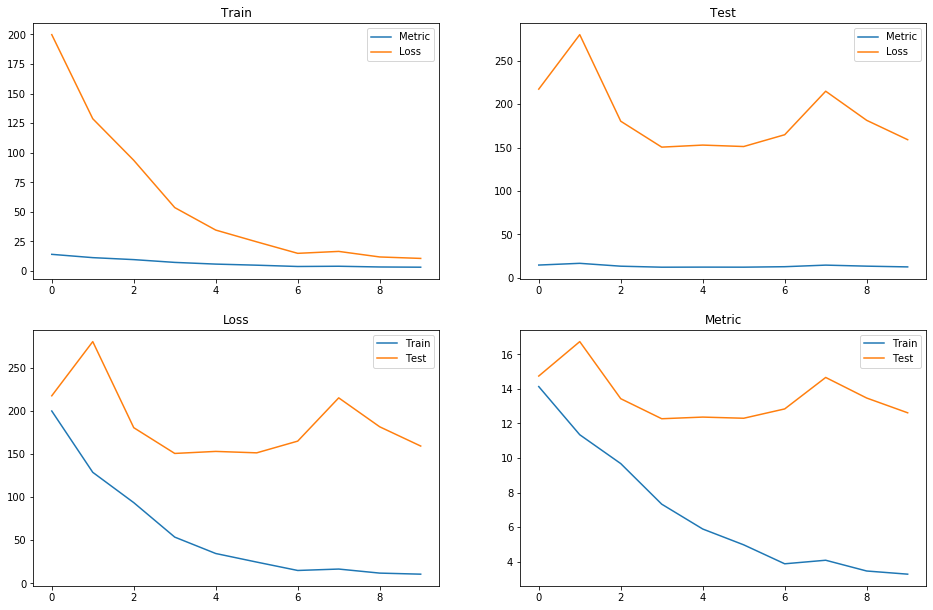

In [27]:
    fig = plt.figure()
    fig.set_size_inches(16,16)

    ax=fig.add_subplot(3,2,1)
    ax.plot(hist.history['rmse'])
    ax.plot(hist.history['mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Train')

    ax=fig.add_subplot(3,2,2)
    ax.plot(hist.history['val_rmse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Metric', 'Loss'])
    ax.set_title('Test')

    ax=fig.add_subplot(3,2,3)
    ax.plot(hist.history['mse'])
    ax.plot(hist.history['val_mse'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Loss')

    ax=fig.add_subplot(3,2,4)
    ax.plot(hist.history['rmse'])
    ax.plot(hist.history['val_rmse'])
    ax.legend(['Train', 'Test'])
    ax.set_title('Metric')